# MLPNN Exercise

The target of this assignment is to design and implement bp-MLPNN with at least two different error functions for [MNIST](http://yann.lecun.com/exdb/mnist/) handwritten digit classification.

## Table of Contents

- [1-Packages](#1)
- [2-Load the Dataset](#2)
- [3-Skeleton of SVM](#3)
- [4-Training with Cross-Entropy Loss](#4)
- [5-Training with KL-Divergence Loss](#5)

<a name='1'></a>

## 1 - Packages

First import all the packages needed during this assignment.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.datasets import fetch_openml
from tqdm import tqdm

%matplotlib inline

%load_ext autoreload
%autoreload 2

np.random.seed(1) # set a seed so that the results are consistent

<a name='2'></a>

## 2 - Load the Dataset

In [2]:
# Load MNIST dataset via sklearn
data, target = fetch_openml('mnist_784', return_X_y=True)

data = data.to_numpy() / 255.0
target = target.to_numpy().astype(np.uint8)

n_samples = 60000  # MNIST dataset uses 60000 examples for training

train_img = data[:n_samples, :]
train_label = target[:n_samples]
test_img = data[n_samples:]
test_label = target[n_samples:]

In [3]:
# As a sanity check, print out the size of the training and test data
print('Training data shape: ', train_img.shape)
print('Training labels shape: ', train_label.shape)
print('Test data shape: ', test_img.shape)
print('Test labels shape: ', test_label.shape)

Training data shape:  (60000, 784)
Training labels shape:  (60000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)


<a name='3'></a>

## 3 - Backbone of MLPNN

In [4]:
# Perceptron
class Perceptron:
    def __init__(self, dim, activation):
        super().__init__()
        self.act = activation
        self.w = np.random.randn(dim, 1)  # column vector
        self.b = np.random.rand()
    
    def __call__(self, x):
        '''forward pass'''
        Z = np.dot(x, self.w) + self.b
        if self.act:
            A = self.act(Z)
            return Z, A
        else:
            return Z

In [5]:
def softmax(X):
    X_exp = np.exp(X)
    partition = np.sum(X_exp, axis=1, keepdims=True)
    return X_exp / partition

In [6]:
class MLPNN:
    def __init__(self, in_dim, out_dim, n_neuron):
        super().__init__()
        
        self.layer1 = [Perceptron(in_dim, activation=np.tanh) for _ in range(n_neuron)]  # use tanh for activation
        self.layer2 = [Perceptron(n_neuron, activation=softmax) for _ in range(out_dim)]  # softmax activation
        
        # vectorize to accerlate
        self._vectorize()
        
        # for back-prop
        self.cache = dict()
        
    
    def __call__(self, x, requires_cache=True):
        '''forward pass'''
        
        # Input Layer -> Hidden Layer
        layer1_input = x
        Z1 = np.dot(layer1_input, self.W1) + self.b1
        A1 = self._activate(Z1, layer_idx=1)
        
        if requires_cache:
            self.cache['Z1'] = Z1
            self.cache['A1'] = A1
            
        # Hidden Layer -> Output Layer
        layer2_input = A1
        Z2 = np.dot(layer2_input, self.W2) + self.b2  
        A2 = self._activate(Z2, layer_idx=2)  # size*C, probility of each class
        
        if requires_cache:
            self.cache['Z2'] = Z2
            self.cache['A2'] = A2
        
        return A2.clip(min=1e-8, max=None)
    
    def _vectorize(self):
        self.W1 = np.hstack([neuron.w for neuron in self.layer1])  # dim * n_hidden
        self.b1 = np.array([neuron.b for neuron in self.layer1])  # n_hidden
        self.W2 = np.hstack([neuron.w for neuron in self.layer2])  # n_hidden * 10
        self.b2 = np.array([neuron.b for neuron in self.layer2])  # 10
        
        self.act1 = [neuron.act for neuron in self.layer1]
        if all(x==self.act1[0] for x in self.act1):  # check if all perceptrons are using the same activation
            self.act1 = self.act1[0]
            
        self.act2 = [neuron.act for neuron in self.layer2]
        if all(x==self.act2[0] for x in self.act2):  # check if all perceptrons are using the same activation
            self.act2 = self.act2[0]
        
        del self.layer1
        del self.layer2
        
    def _activate(self, feat, layer_idx):
        assert layer_idx in (1, 2)  # since we're using two layer neural network
        
        act = self.act1 if layer_idx == 1 else self.act2
        
        if callable(act):
            return act(feat)
        elif type(act) is list:
            assert len(act) == feat.shape[1]
            for i in range(feat.shape[1]):
                feat[:, i] = act[i](feat[:, i])
            return feat
        else:
            raise Exception('Internal error')

<a name='4'></a>

## 4 - Training with Cross-Entropy Loss

For Multi-class classification problem, cross-entropy loss is defined as

$$
L(\hat{y}, y)=-\sum_{k}^{K} y^{(k)} \log \hat{y}^{(k)}
$$

where $y^{(k)}$ is $0$ or $1$, indicating whether class label $k$ is the correct classification.

In [7]:
def to_one_hot(values):
    values = np.squeeze(values)
    n_values = np.max(values) + 1
    return np.eye(n_values)[values].astype(np.uint8)

def compute_loss(output, Y):
    """ Computes cross entropy between two distributions.
    Input: x: iterabale of N non-negative values
           y: iterabale of N non-negative values
    Returns: scalar
    """
    return -np.sum(np.multiply(to_one_hot(Y), np.log(output)))

In [8]:
def bp_cross_entropy(network, X, Y, lr):
    n = X.shape[0]  # size of dataset
    
    A1 = network.cache['A1']
    A2 = network.cache['A2']
    
    # compute gradients
    dZ2 = A2 - to_one_hot(Y)
    dW2 = (1 / n) * np.dot(A1.T, dZ2)
    db2 = (1 / n) * np.sum(dZ2, axis=0)
    
    dZ1 = np.multiply(np.dot(dZ2, network.W2.T), 1 - np.power(A1, 2))
    dW1 = (1 / n) * np.dot(X.T, dZ1)
    db1 = (1 / n) * np.sum(dZ1, axis=0)
    
    # update parameters
    network.W2 = network.W2 - lr * dW2
    network.b2 = network.b2 - lr * db2
    network.W1 = network.W1 - lr * dW1
    network.b1 = network.b1 - lr * db1

 10%|███▊                                  | 199/2000 [18:11<2:48:54,  5.63s/it]

[epoch 200] loss: 140015.9757


 20%|███████▌                              | 399/2000 [36:09<2:20:03,  5.25s/it]

[epoch 400] loss: 98761.8062


 30%|███████████▍                          | 599/2000 [53:27<1:59:15,  5.11s/it]

[epoch 600] loss: 79200.0926


 40%|██████████████▍                     | 799/2000 [1:10:44<1:51:25,  5.57s/it]

[epoch 800] loss: 66535.5184


 50%|█████████████████▉                  | 999/2000 [1:28:43<1:29:44,  5.38s/it]

[epoch 1000] loss: 57299.7318


 60%|████████████████████▉              | 1199/2000 [1:46:49<1:07:26,  5.05s/it]

[epoch 1200] loss: 50137.3821


 70%|█████████████████████████▉           | 1399/2000 [2:03:41<50:41,  5.06s/it]

[epoch 1400] loss: 44356.6473


 80%|█████████████████████████████▌       | 1599/2000 [2:20:32<33:44,  5.05s/it]

[epoch 1600] loss: 39598.9911


 90%|█████████████████████████████████▎   | 1799/2000 [2:37:24<16:55,  5.05s/it]

[epoch 1800] loss: 35571.1231


100%|████████████████████████████████████▉| 1999/2000 [2:54:16<00:05,  5.06s/it]

[epoch 2000] loss: 32051.5763


100%|█████████████████████████████████████| 2000/2000 [2:54:21<00:00,  5.23s/it]


Text(0, 0.5, 'Cross-Entropy Loss')

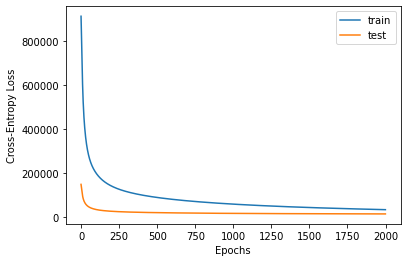

In [9]:
network = MLPNN(in_dim=784, out_dim=10, n_neuron=1000)
learning_rate = 1e-1
epochs = 2000

training_loss = list()
testing_loss = list()

for epoch in tqdm(range(1, epochs+1)):
    out = network(train_img)
    loss = compute_loss(out, train_label)
    training_loss.append(loss)
    bp_cross_entropy(network, train_img, train_label, learning_rate)
    
    if epoch % 200 == 0:
        print('[epoch %d] loss: %.4f' % (epoch, loss))
    
    # Evaluate on testing set
    out = network(test_img, requires_cache=False)
    loss = compute_loss(out, test_label)
    testing_loss.append(loss)
        
# Plot loss curve
p1, = plt.plot(training_loss)
p2, = plt.plot(testing_loss)
plt.legend(handles=[p1, p2], labels=['train', 'test'], loc='best')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')

In [10]:
def evaluate(network, X, Y):
    pred = np.argmax(network(X), axis=1).reshape(-1)
    cm = metrics.confusion_matrix(Y, pred)
    print("Confusion matrix:\n%s" % cm)
    print("Accuracy={}".format(metrics.accuracy_score(Y, pred)))
    
evaluate(network, test_img, test_label)

Confusion matrix:
[[ 914    0    6    3    2   23   13    6   11    2]
 [   0 1098    8    6    1    3    3    2   13    1]
 [  11    9  898   29   11    5   14   11   37    7]
 [   4    4   12  890    1   44    1   11   33   10]
 [   3    3   10    1  866    3   14   18   12   52]
 [  12    3    9   41   11  744   13    8   43    8]
 [  17    3   18    4   17   15  876    2    4    2]
 [   4    7   27   12   11    2    1  919    7   38]
 [  13    6   21   35   11   41   14   14  801   18]
 [  10    5    1   14   58    6    4   33   18  860]]
Accuracy=0.8866


<a name='5'></a>

## 5 - Training with KL-Divergence Loss

Kullback Leibler Divergence, or KL Divergence for short, is a measure of how one probability distribution differs from a baseline distribution. For Multi-class classification problem, KL-Divergence loss is defined as

$$
L(\hat{y}, y)=\sum_{k}^{K} y^{(k)} (\log \hat{y}^{(k)} - \log y^{(k)})
$$

where $y^{(k)}$ is $0$ or $1$, indicating whether class label $k$ is the correct classification.

In [11]:
def compute_loss(output, Y):
    y = to_one_hot(Y)
    return -np.sum(np.where(y != 0, np.multiply(y, np.log(output / y)), 0))

In [12]:
# Note that code is same with back prop in cross-entropy
# since both losses has same derivative w.r.t y hat
def bp_kl(network, X, Y, lr):
    n = X.shape[0]  # size of dataset
    
    A1 = network.cache['A1']
    A2 = network.cache['A2']
    
    # compute gradients
    dZ2 = A2 - to_one_hot(Y)
    dW2 = (1 / n) * np.dot(A1.T, dZ2)
    db2 = (1 / n) * np.sum(dZ2, axis=0)
    
    dZ1 = np.multiply(np.dot(dZ2, network.W2.T), 1 - np.power(A1, 2))
    dW1 = (1 / n) * np.dot(X.T, dZ1)
    db1 = (1 / n) * np.sum(dZ1, axis=0)
    
    # update parameters
    network.W2 = network.W2 - lr * dW2
    network.b2 = network.b2 - lr * db2
    network.W1 = network.W1 - lr * dW1
    network.b1 = network.b1 - lr * db1

  0%|                                                  | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_184119/221692360.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum(np.where(y != 0, np.multiply(y, np.log(output / y)), 0))
/tmp/ipykernel_184119/221692360.py:3: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(y != 0, np.multiply(y, np.log(output / y)), 0))
 10%|███▊                                  | 199/2000 [16:46<2:31:45,  5.06s/it]

[epoch 200] loss: -143104.7662


 20%|███████▌                              | 399/2000 [33:38<2:15:24,  5.07s/it]

[epoch 400] loss: -101351.5404


 30%|███████████▍                          | 599/2000 [50:30<1:58:13,  5.06s/it]

[epoch 600] loss: -81278.7056


 40%|██████████████▍                     | 799/2000 [1:07:21<1:41:17,  5.06s/it]

[epoch 800] loss: -67875.5278


 50%|█████████████████▉                  | 999/2000 [1:24:13<1:24:22,  5.06s/it]

[epoch 1000] loss: -58113.3984


 60%|████████████████████▉              | 1199/2000 [1:41:05<1:07:28,  5.05s/it]

[epoch 1200] loss: -50524.0959


 70%|█████████████████████████▉           | 1399/2000 [1:58:33<54:21,  5.43s/it]

[epoch 1400] loss: -44438.4743


 80%|█████████████████████████████▌       | 1599/2000 [2:16:50<36:43,  5.50s/it]

[epoch 1600] loss: -39468.1728


 90%|█████████████████████████████████▎   | 1799/2000 [2:34:03<17:44,  5.29s/it]

[epoch 1800] loss: -35320.9407


100%|████████████████████████████████████▉| 1999/2000 [2:51:22<00:05,  5.06s/it]

[epoch 2000] loss: -31768.7917


100%|█████████████████████████████████████| 2000/2000 [2:51:27<00:00,  5.14s/it]


Text(0, 0.5, 'KL-Divergence Loss')

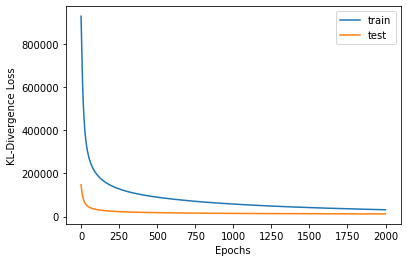

In [13]:
network = MLPNN(in_dim=784, out_dim=10, n_neuron=1000)
learning_rate = 1e-1
epochs = 2000

training_loss = list()
testing_loss = list()

for epoch in tqdm(range(1, epochs+1)):
    out = network(train_img)
    loss = compute_loss(out, train_label)
    training_loss.append(loss)
    bp_kl(network, train_img, train_label, learning_rate)
    
    if epoch % 200 == 0:
        print('[epoch %d] loss: %.4f' % (epoch, loss))
    
    # Evaluate on testing set
    out = network(test_img, requires_cache=False)
    loss = compute_loss(out, test_label)
    testing_loss.append(loss)
        
# Plot loss curve
p1, = plt.plot(training_loss)
p2, = plt.plot(testing_loss)
plt.legend(handles=[p1, p2], labels=['train', 'test'], loc='best')
plt.xlabel('Epochs')
plt.ylabel('KL-Divergence Loss')

In [14]:
evaluate(network, test_img, test_label)

Confusion matrix:
[[ 920    1   11    6    1   17   15    2    6    1]
 [   0 1091    6    6    1    4    5    4   17    1]
 [  17    7  906   22    9   12   13   10   31    5]
 [   4    4   16  893    2   33    2   16   27   13]
 [   7    1   12    5  864    3   19    5   14   52]
 [  10    5   13   34   13  751   16    7   31   12]
 [  13    3   14    3   16   25  868    0   15    1]
 [   4    9   31   14   13    8    1  897    3   48]
 [   9    6   16   33   13   37   12   10  819   19]
 [   5    8    6    9   51   11    3   33   24  859]]
Accuracy=0.8868
